# Nadaraya-Watson 核回归

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

# 生成数据集

In [25]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
x_train, x_train.shape

(tensor([0.1790, 0.1978, 0.2599, 0.4025, 0.5018, 0.5527, 0.5770, 0.5967, 0.7498,
         0.9433, 1.0007, 1.1585, 1.1708, 1.3494, 1.6429, 1.7331, 1.7508, 2.0416,
         2.1441, 2.1802, 2.2488, 2.4079, 2.5021, 2.6084, 2.8379, 2.9166, 3.0201,
         3.0528, 3.4547, 3.4727, 3.5233, 3.5538, 3.5574, 3.6604, 3.6982, 3.8498,
         3.8521, 3.8691, 3.9354, 4.1149, 4.1317, 4.1854, 4.3104, 4.5113, 4.6250,
         4.6499, 4.6646, 4.7154, 4.8530, 4.8554]),
 torch.Size([50]))

In [26]:
def f(x): # 真实的 函数 ，后边学习参数拟合这个
    return 2 * torch.sin(x) + x**0.8

In [27]:
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [28]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

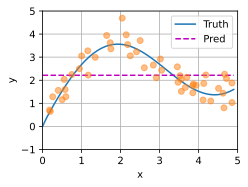

In [29]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

# 非参数注意力 池化

In [43]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train)) # 重复50次
X_repeat.shape, X_repeat[1], X_repeat[2]
# X_repeat的形状:(n_test, n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）

(torch.Size([50, 50]),
 tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000]),
 tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))

In [35]:
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
attention_weights.shape

torch.Size([50, 50])

In [37]:
y_hat = torch.matmul(attention_weights, y_train)
y_hat.shape

torch.Size([50])

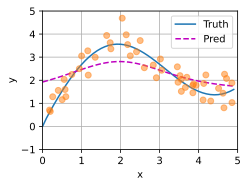

In [38]:
plot_kernel_reg(y_hat)

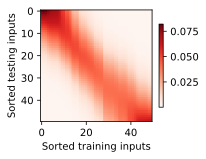

In [39]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 带参数注意力池化
假定两个张量的形状分别是(n, a, b)和(n, b, c),它们的批量矩阵乘法输出的形状为(n, a, c)。

In [44]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))

torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [53]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

# 将训练数据集转换为健和值

In [54]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

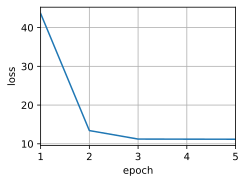

In [55]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

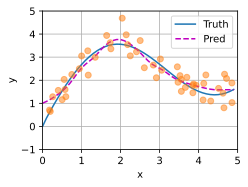

In [56]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

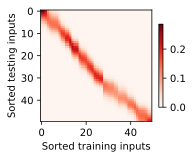

In [57]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')